In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/newparticulate_covidstat.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpm10_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = in_datapaper
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   arezzo
   2   belluno
   3   bologna
   4   latina
   5   perugia
   6   padova
   7   l_aquila
   8   agrigento
   9   novara
   10   lecco
   11   caserta
   12   monza
   13   ravenna
   14   benevento
   15   teramo
   16   avellino
   17   roma
   18   mantova
   19   livorno
   20   la_spezia
   21   genova
   22   vercelli
   23   catanzaro
   24   pordenone
   25   frosinone
   26   como
   27   nuoro
   28   cuneo
   29   verona
   30   viterbo
   31   vibo_valentia
   32   siracusa
   33   savona
   34   firenze
   35   fermo
   36   sassari
   37   carbonia
   38   cremona
   39   foggia
   40   potenza
   41   ferrara
   42   varese
   43   cosenza
   44   pisa
   45   campobasso
   46   bergamo
   47   massa
   48   rieti
   49   modena
   50   lucca
   51   salerno
   52   ancona
   53   ascoli_piceno
   54   bolzano
   55   oristano
   56   brindisi
   57   reggio_nell_emilia
   58   milano


In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 arezzo
2 belluno
3 bologna
4 latina
5 perugia
6 padova
7 l_aquila
8 agrigento
9 novara
10 lecco
11 caserta
12 monza
13 ravenna
14 benevento
15 teramo
16 avellino
17 roma
18 mantova
19 livorno
20 la_spezia
21 genova
22 vercelli
23 catanzaro
24 pordenone
25 frosinone
26 como
27 nuoro
28 cuneo
29 verona
30 viterbo
31 vibo_valentia
32 siracusa
33 savona
34 firenze
35 fermo
36 sassari
37 cremona
38 foggia
39 potenza
40 ferrara
41 varese
42 cosenza
43 pisa
44 campobasso
45 bergamo
46 massa
47 rieti
48 modena
49 lucca
50 salerno
51 ancona
52 ascoli_piceno
53 bolzano
54 oristano
55 brindisi
56 reggio_nell_emilia
57 milano
58 matera
59 forli
60 sondrio
61 prato
62 taranto
63 pesaro
64 parma
65 bat
66 siena
67 pavia
68 verbania
69 brescia
70 rimini
71 terni
72 trapani
73 macerata
74 crotone
75 venezia
76 trento
77 grosseto
78 enna
79 asti
80 lecce
81 reggio_di_calabria
82 cagliari
83 caltanissetta
84 chieti
85 catania
86 rovigo
87 palermo
88 lodi
89 alessandria
90 udine
91 bari
92 vicenza
93 p

In [4]:
#add random feature
import random

#featurestobeused += ",randomfeature"
#features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

#random.seed(1)
#for i in range(len(ylogpropcasi)):
#    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Using:                        density
Using:               commutersdensity
Using:                         depriv
Using:                            lat
Using:                 Ratio0200ver65
Using:         avg_wpm10_period1_2020
Using:          avg_wso2_period1_2020
Using:           avg_wno_period1_2020

 


In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

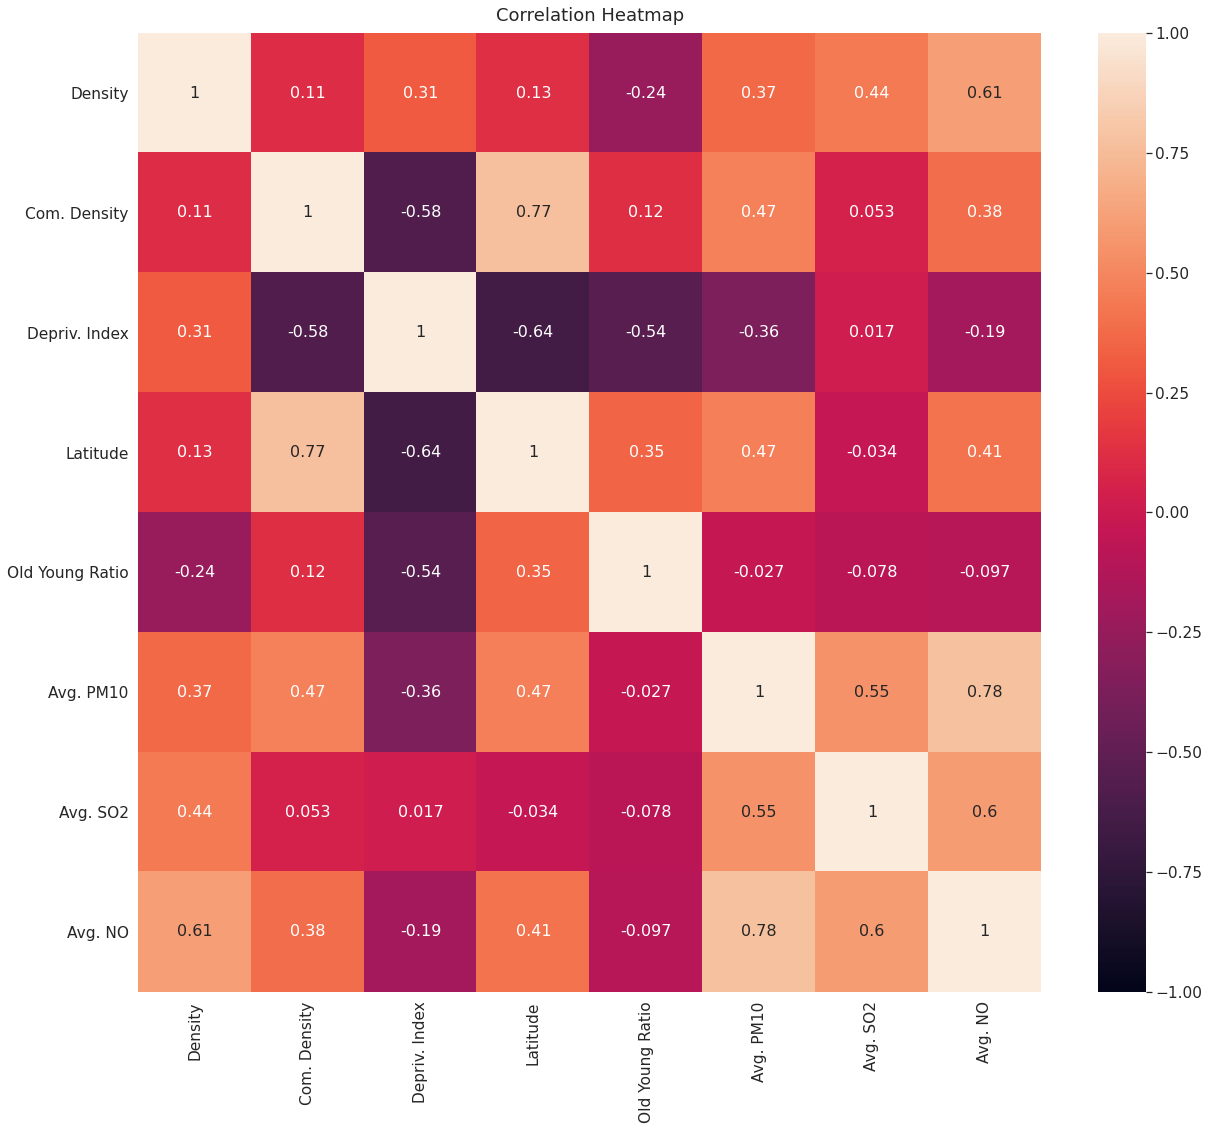

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.33006  0.02165 
    Test set average RMSE:  0.89308  0.09634 

Prediction STD :    1.25439
True value STD :    1.43281
Difference in percentage:   12.45238

             Fullset RMSE:    0.32260
                       R2:    0.94931


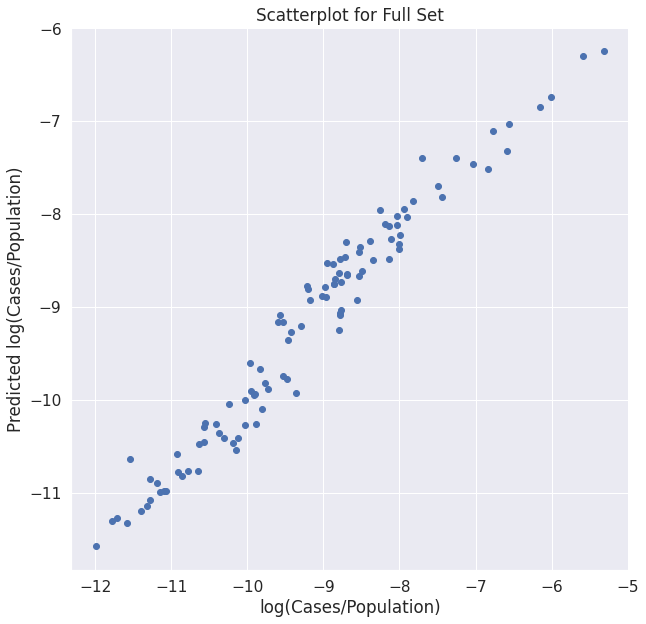

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07145 +/- 0.00618
Feature:                   Com. Density, Score: 0.23739 +/- 0.04413
Feature:                  Depriv. Index, Score: 0.15423 +/- 0.01921
Feature:                       Latitude, Score: 0.81988 +/- 0.11379
Feature:                Old Young Ratio, Score: 0.11584 +/- 0.01575
Feature:                      Avg. PM10, Score: 0.18231 +/- 0.02557
Feature:                       Avg. SO2, Score: 0.10038 +/- 0.01255
Feature:                        Avg. NO, Score: 0.23144 +/- 0.03204


<Figure size 432x288 with 0 Axes>

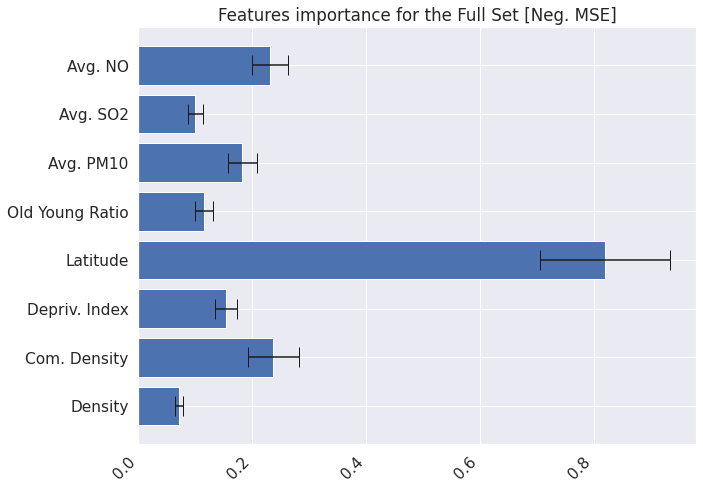

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03480 +/- 0.00301
Feature:                   Com. Density, Score: 0.11563 +/- 0.02149
Feature:                  Depriv. Index, Score: 0.07513 +/- 0.00936
Feature:                       Latitude, Score: 0.39937 +/- 0.05543
Feature:                Old Young Ratio, Score: 0.05643 +/- 0.00767
Feature:                      Avg. PM10, Score: 0.08880 +/- 0.01245
Feature:                       Avg. SO2, Score: 0.04890 +/- 0.00611
Feature:                        Avg. NO, Score: 0.11273 +/- 0.01561


<Figure size 432x288 with 0 Axes>

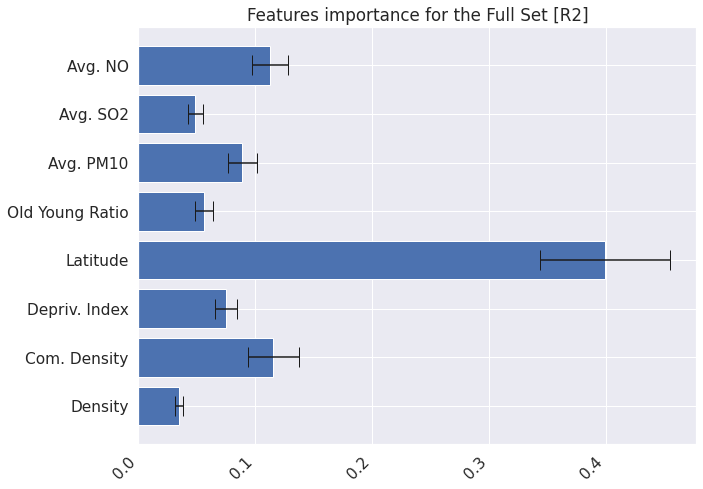

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.28445
                       R2:    0.95516


<Figure size 432x288 with 0 Axes>

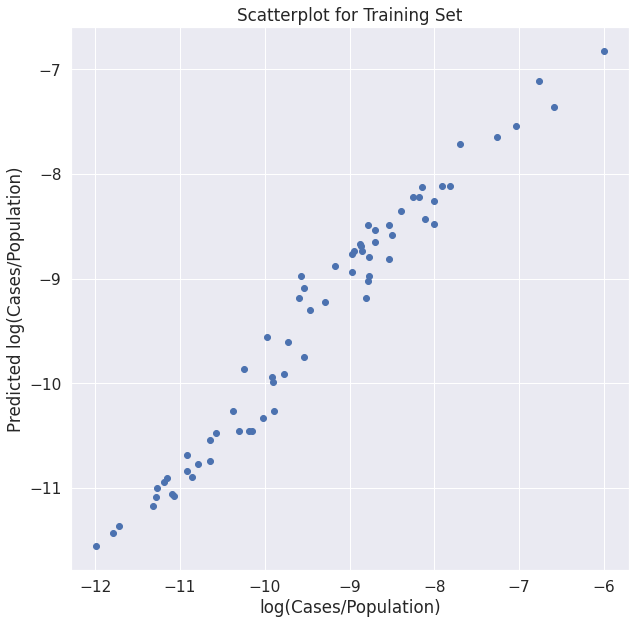

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.08724
                       R2:    0.48149


<Figure size 432x288 with 0 Axes>

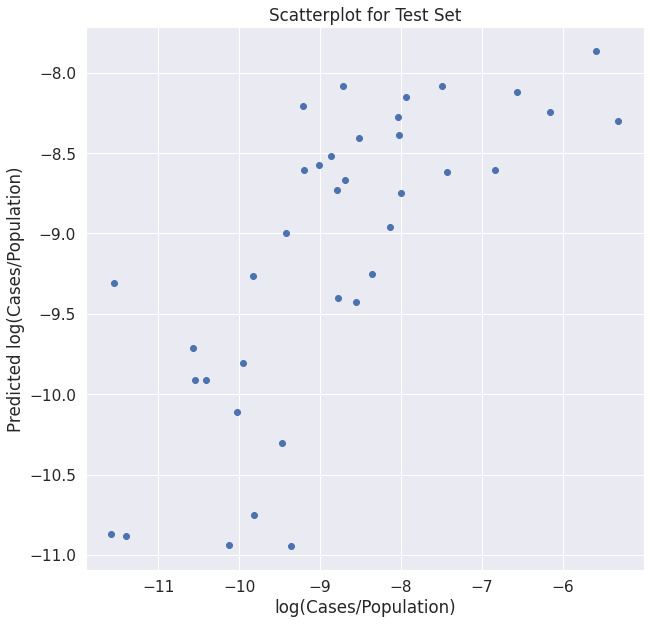

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.11985 +/- 0.07780
Feature:                  Depriv. Index, Score: 0.08390 +/- 0.05487
Feature:                       Latitude, Score: 0.46631 +/- 0.13822
Feature:                Old Young Ratio, Score: 0.05622 +/- 0.03000
Feature:                      Avg. PM10, Score: 0.06528 +/- 0.04457
Feature:                       Avg. SO2, Score: 0.03527 +/- 0.02322
Feature:                        Avg. NO, Score: 0.05683 +/- 0.04048


<Figure size 432x288 with 0 Axes>

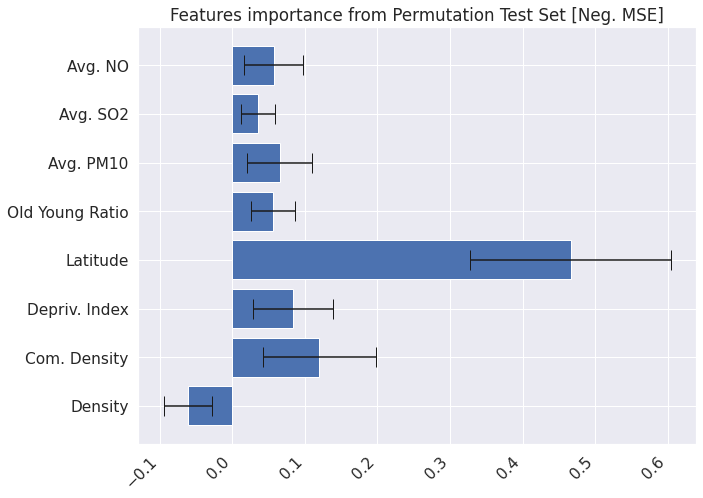

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.05257 +/- 0.03413
Feature:                  Depriv. Index, Score: 0.03680 +/- 0.02407
Feature:                       Latitude, Score: 0.20454 +/- 0.06063
Feature:                Old Young Ratio, Score: 0.02466 +/- 0.01316
Feature:                      Avg. PM10, Score: 0.02863 +/- 0.01955
Feature:                       Avg. SO2, Score: 0.01547 +/- 0.01018
Feature:                        Avg. NO, Score: 0.02493 +/- 0.01776


<Figure size 432x288 with 0 Axes>

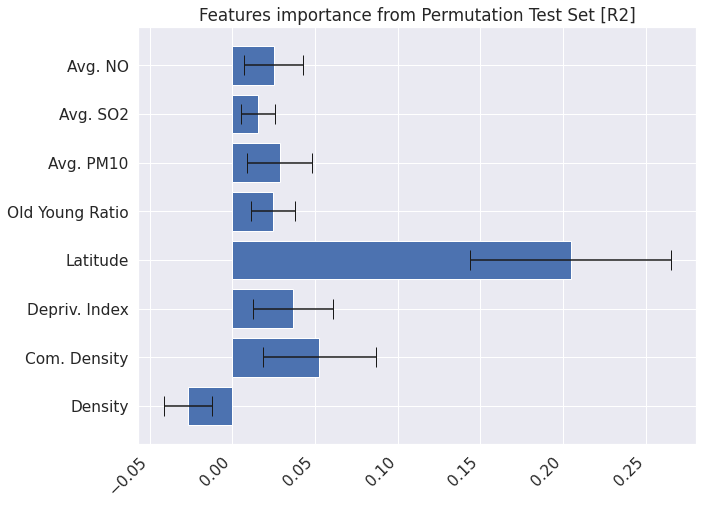

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07725 +/- 0.01348
Feature:                   Com. Density, Score: 0.26007 +/- 0.04394
Feature:                  Depriv. Index, Score: 0.16493 +/- 0.02714
Feature:                       Latitude, Score: 0.51521 +/- 0.07692
Feature:                Old Young Ratio, Score: 0.09546 +/- 0.01720
Feature:                      Avg. PM10, Score: 0.14114 +/- 0.02463
Feature:                       Avg. SO2, Score: 0.07277 +/- 0.01223
Feature:                        Avg. NO, Score: 0.12448 +/- 0.01935


<Figure size 432x288 with 0 Axes>

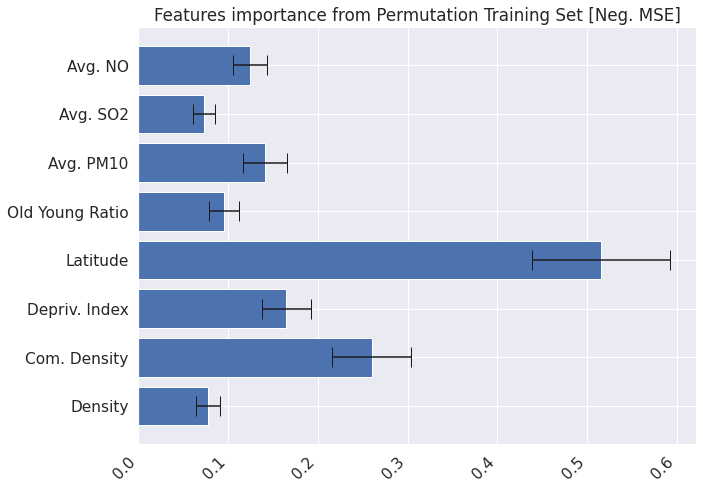

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.04281 +/- 0.00747
Feature:                   Com. Density, Score: 0.14412 +/- 0.02435
Feature:                  Depriv. Index, Score: 0.09140 +/- 0.01504
Feature:                       Latitude, Score: 0.28552 +/- 0.04263
Feature:                Old Young Ratio, Score: 0.05290 +/- 0.00953
Feature:                      Avg. PM10, Score: 0.07821 +/- 0.01365
Feature:                       Avg. SO2, Score: 0.04032 +/- 0.00678
Feature:                        Avg. NO, Score: 0.06898 +/- 0.01073


<Figure size 432x288 with 0 Axes>

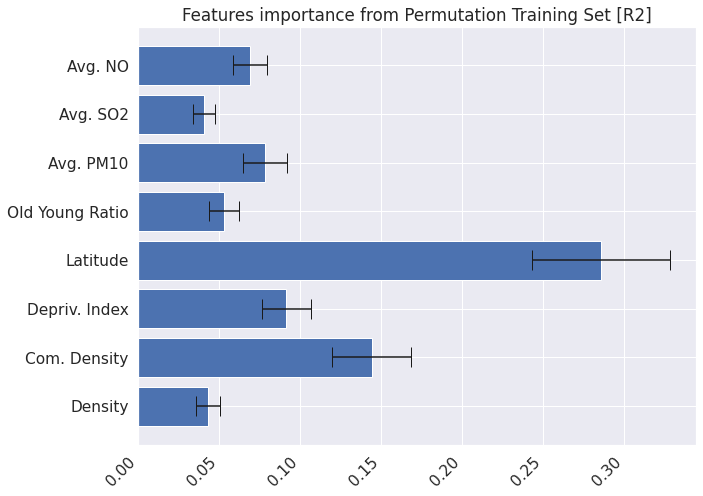

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35441  0.01939 
    Test set average RMSE:  0.95113  0.08814 

Prediction STD :    1.22910
True value STD :    1.43281
Difference in percentage:   14.21743

             Fullset RMSE:    0.34637
                       R2:    0.94156


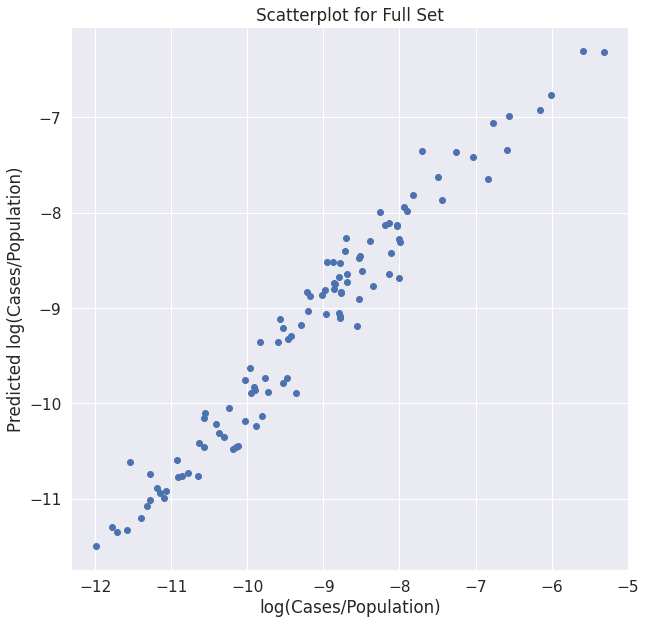

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.09685 +/- 0.00778
Feature:                   Com. Density, Score: 0.64360 +/- 0.10456
Feature:                  Depriv. Index, Score: 0.28428 +/- 0.04109
Feature:                Old Young Ratio, Score: 0.16653 +/- 0.02107
Feature:                      Avg. PM10, Score: 0.30358 +/- 0.04706
Feature:                       Avg. SO2, Score: 0.15868 +/- 0.01961
Feature:                        Avg. NO, Score: 0.35973 +/- 0.05036


<Figure size 432x288 with 0 Axes>

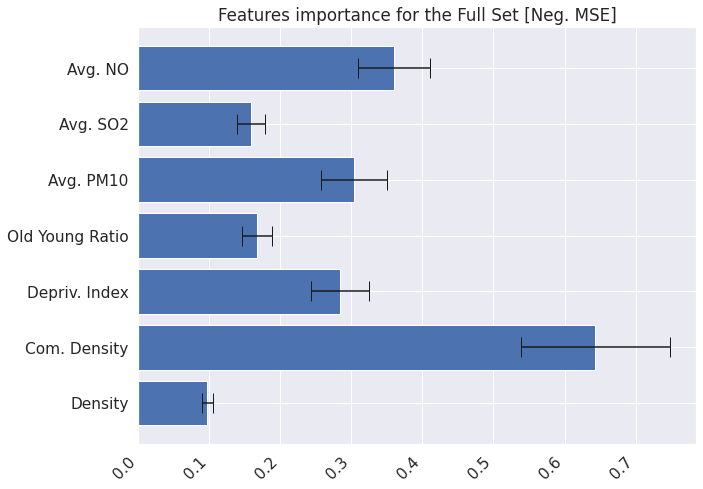

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.04718 +/- 0.00379
Feature:                   Com. Density, Score: 0.31350 +/- 0.05093
Feature:                  Depriv. Index, Score: 0.13847 +/- 0.02002
Feature:                Old Young Ratio, Score: 0.08112 +/- 0.01026
Feature:                      Avg. PM10, Score: 0.14788 +/- 0.02292
Feature:                       Avg. SO2, Score: 0.07730 +/- 0.00955
Feature:                        Avg. NO, Score: 0.17523 +/- 0.02453


<Figure size 432x288 with 0 Axes>

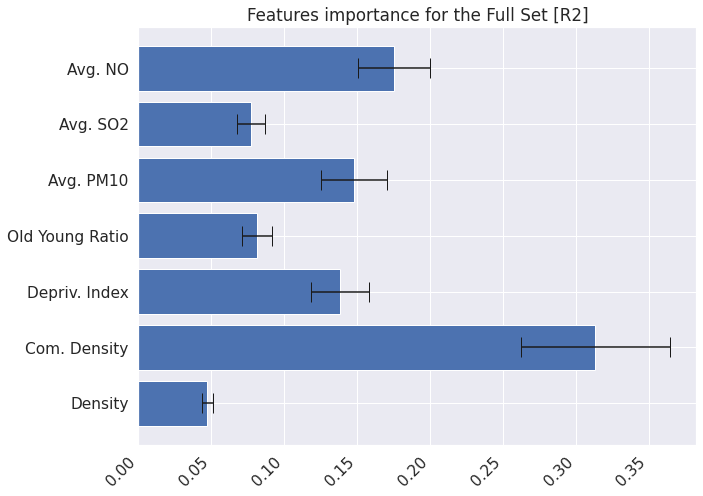

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.34735
                       R2:    0.93020


<Figure size 432x288 with 0 Axes>

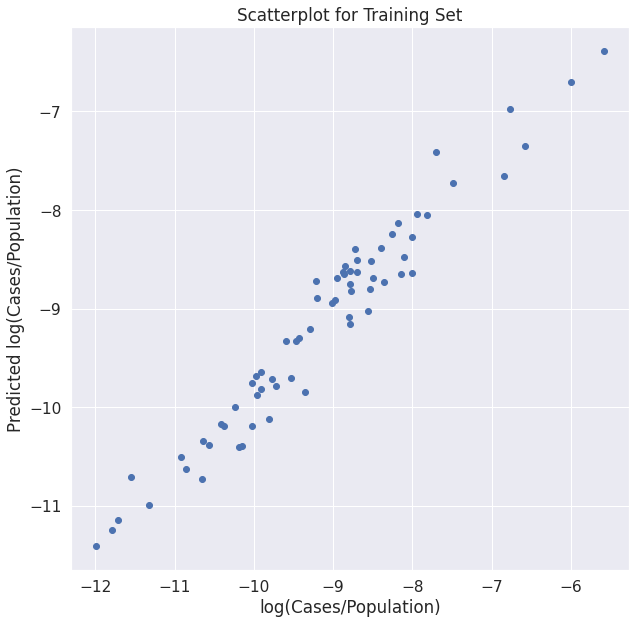

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.04510
                       R2:    0.58482


<Figure size 432x288 with 0 Axes>

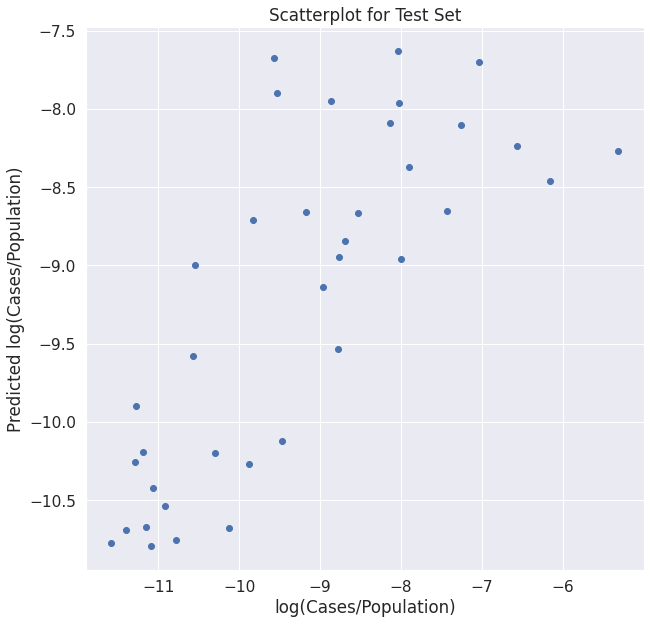

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.51188 +/- 0.14606
Feature:                  Depriv. Index, Score: 0.05789 +/- 0.06081
Feature:                Old Young Ratio, Score: 0.05156 +/- 0.04100
Feature:                      Avg. PM10, Score: 0.24235 +/- 0.09235
Feature:                       Avg. SO2, Score: 0.02626 +/- 0.03046
Feature:                        Avg. NO, Score: 0.22170 +/- 0.08755


<Figure size 432x288 with 0 Axes>

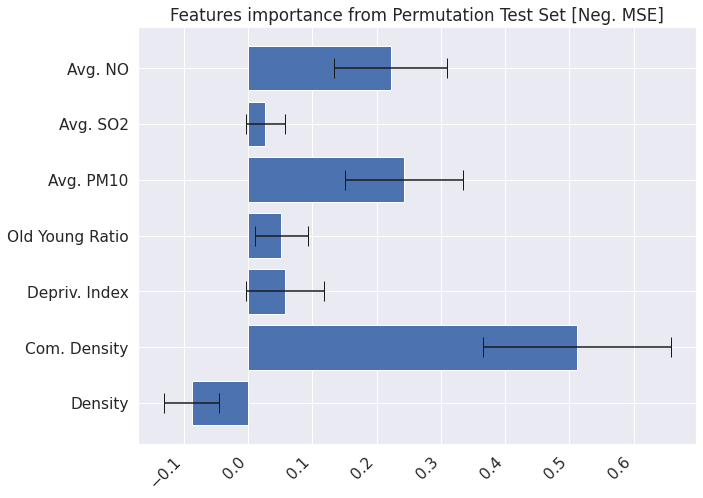

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.19458 +/- 0.05552
Feature:                  Depriv. Index, Score: 0.02201 +/- 0.02312
Feature:                Old Young Ratio, Score: 0.01960 +/- 0.01558
Feature:                      Avg. PM10, Score: 0.09212 +/- 0.03511
Feature:                       Avg. SO2, Score: 0.00998 +/- 0.01158
Feature:                        Avg. NO, Score: 0.08427 +/- 0.03328


<Figure size 432x288 with 0 Axes>

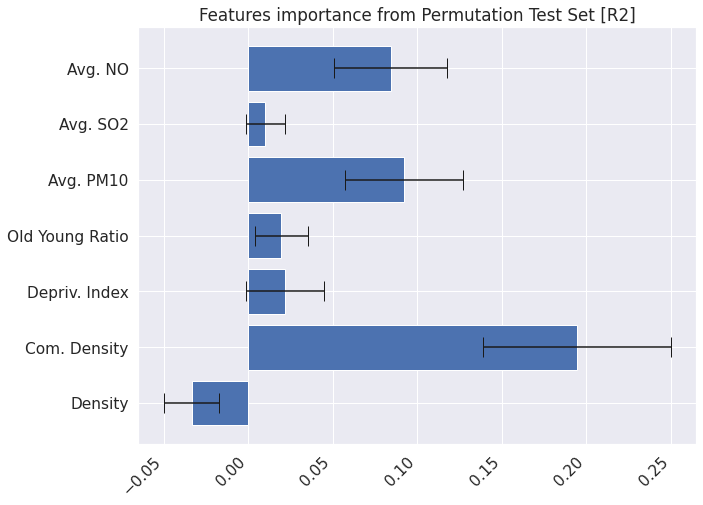

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.11241 +/- 0.01934
Feature:                   Com. Density, Score: 0.43072 +/- 0.07326
Feature:                  Depriv. Index, Score: 0.20071 +/- 0.02982
Feature:                Old Young Ratio, Score: 0.13774 +/- 0.02117
Feature:                      Avg. PM10, Score: 0.37325 +/- 0.07263
Feature:                       Avg. SO2, Score: 0.13107 +/- 0.01856
Feature:                        Avg. NO, Score: 0.26898 +/- 0.05141


<Figure size 432x288 with 0 Axes>

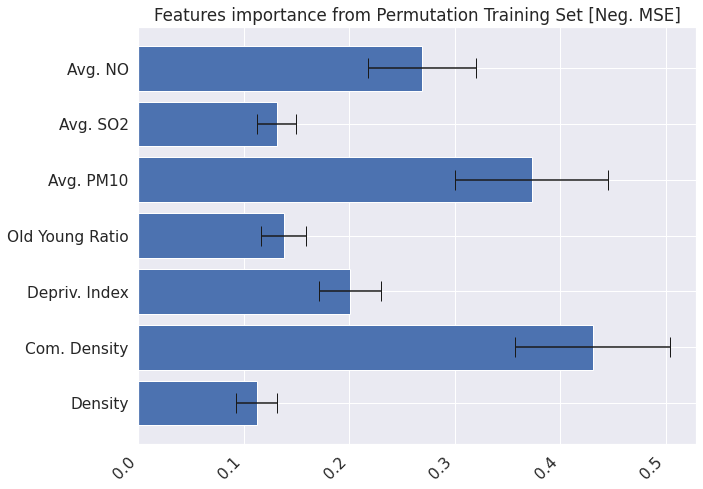

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.06503 +/- 0.01119
Feature:                   Com. Density, Score: 0.24917 +/- 0.04238
Feature:                  Depriv. Index, Score: 0.11612 +/- 0.01725
Feature:                Old Young Ratio, Score: 0.07968 +/- 0.01225
Feature:                      Avg. PM10, Score: 0.21593 +/- 0.04202
Feature:                       Avg. SO2, Score: 0.07582 +/- 0.01074
Feature:                        Avg. NO, Score: 0.15561 +/- 0.02974


<Figure size 432x288 with 0 Axes>

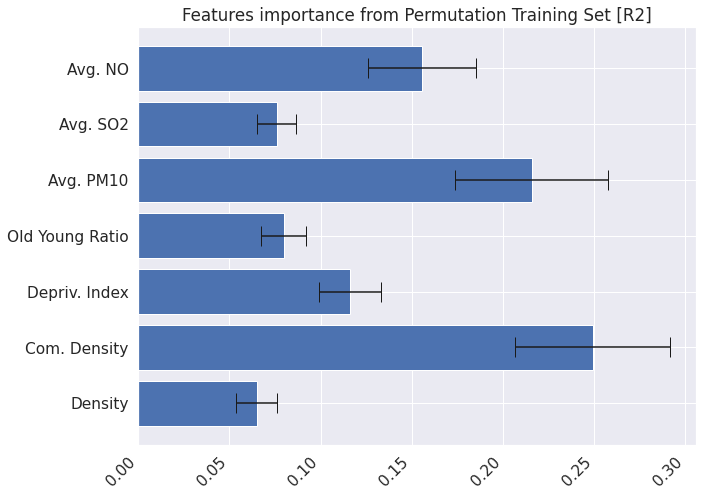

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37260  0.01952 
    Test set average RMSE:  1.02068  0.08245 

Prediction STD :    1.20738
True value STD :    1.43281
Difference in percentage:   15.73333

             Fullset RMSE:    0.35834
                       R2:    0.93745


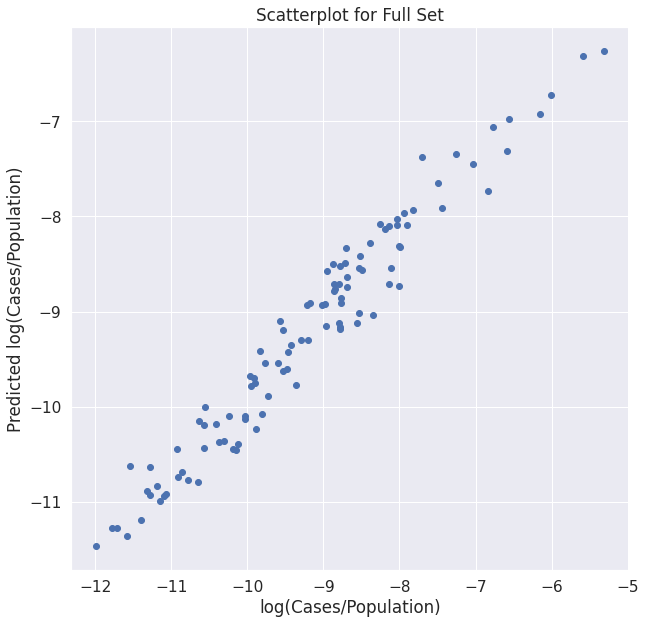

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12727 +/- 0.01153
Feature:                  Depriv. Index, Score: 0.58120 +/- 0.08258
Feature:                Old Young Ratio, Score: 0.21086 +/- 0.02587
Feature:                      Avg. PM10, Score: 0.45797 +/- 0.07223
Feature:                       Avg. SO2, Score: 0.21417 +/- 0.02511
Feature:                        Avg. NO, Score: 0.64099 +/- 0.08657


<Figure size 432x288 with 0 Axes>

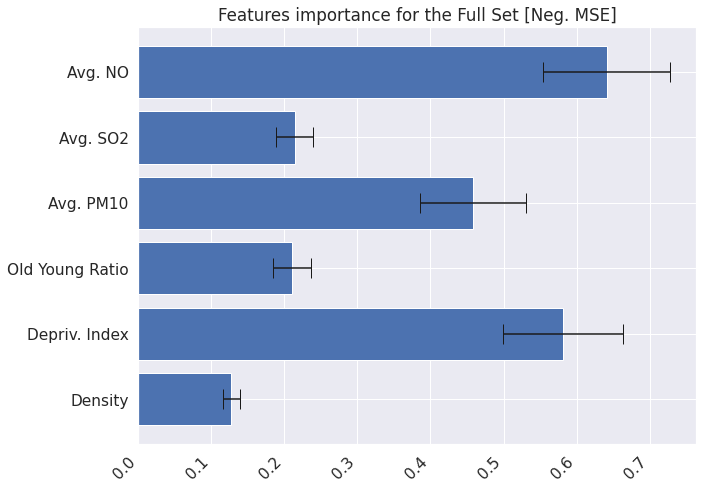

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06199 +/- 0.00562
Feature:                  Depriv. Index, Score: 0.28311 +/- 0.04023
Feature:                Old Young Ratio, Score: 0.10271 +/- 0.01260
Feature:                      Avg. PM10, Score: 0.22308 +/- 0.03519
Feature:                       Avg. SO2, Score: 0.10432 +/- 0.01223
Feature:                        Avg. NO, Score: 0.31223 +/- 0.04217


<Figure size 432x288 with 0 Axes>

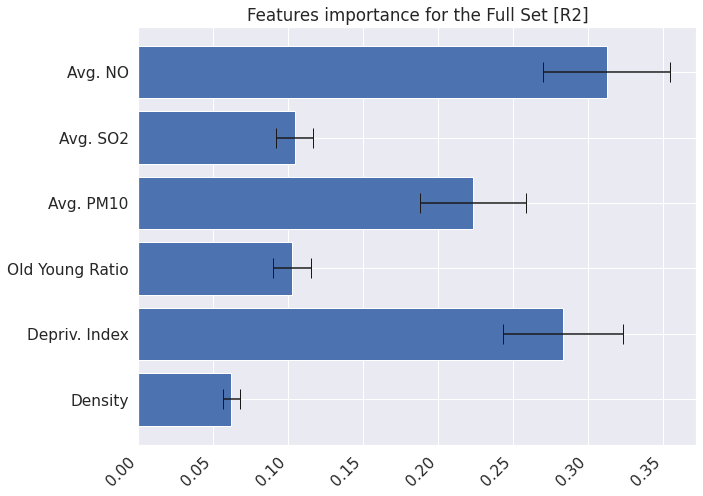

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.38891
                       R2:    0.93089


<Figure size 432x288 with 0 Axes>

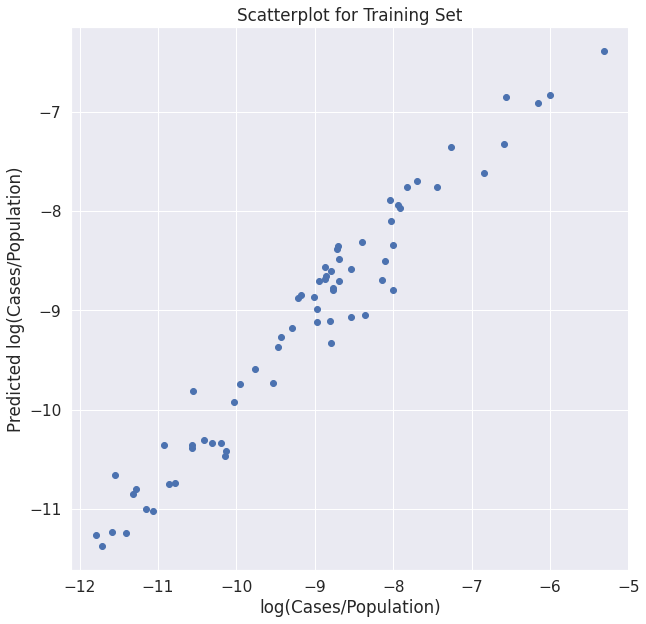

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.96113
                       R2:    0.47970


<Figure size 432x288 with 0 Axes>

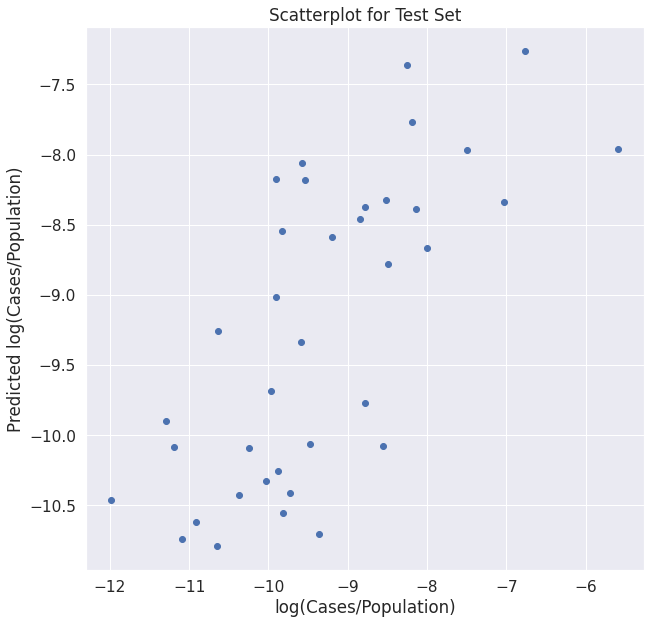

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.50081 +/- 0.15889
Feature:                      Avg. PM10, Score: 0.14509 +/- 0.11228
Feature:                        Avg. NO, Score: 0.16265 +/- 0.15347


<Figure size 432x288 with 0 Axes>

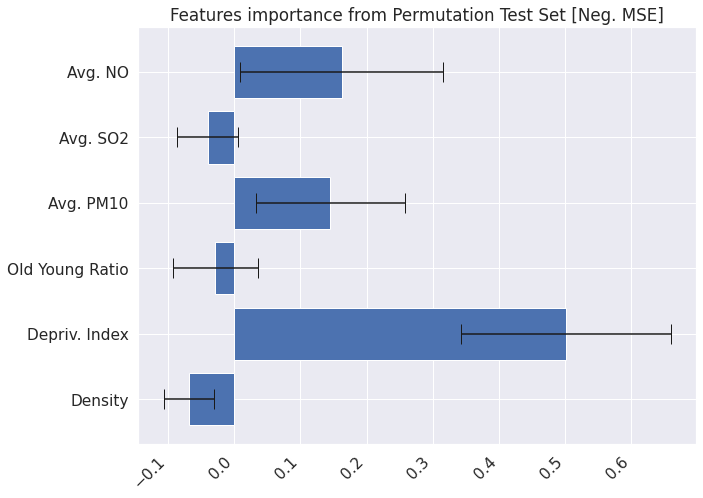

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.28207 +/- 0.08949
Feature:                      Avg. PM10, Score: 0.08172 +/- 0.06324
Feature:                        Avg. NO, Score: 0.09161 +/- 0.08644


<Figure size 432x288 with 0 Axes>

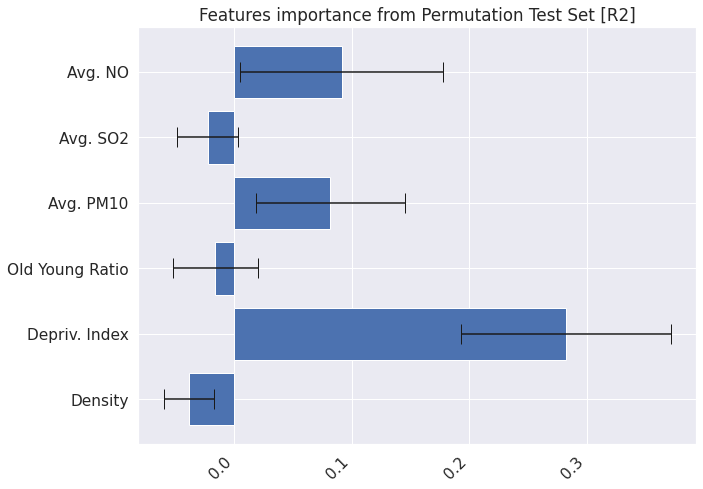

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.15284 +/- 0.02185
Feature:                  Depriv. Index, Score: 0.42348 +/- 0.08528
Feature:                Old Young Ratio, Score: 0.18565 +/- 0.04055
Feature:                      Avg. PM10, Score: 0.45791 +/- 0.07574
Feature:                       Avg. SO2, Score: 0.26569 +/- 0.04044
Feature:                        Avg. NO, Score: 0.74256 +/- 0.11850


<Figure size 432x288 with 0 Axes>

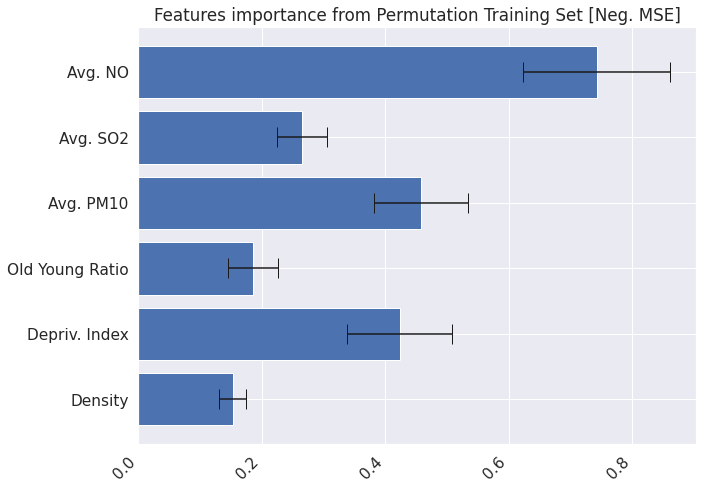

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.06984 +/- 0.00998
Feature:                  Depriv. Index, Score: 0.19349 +/- 0.03896
Feature:                Old Young Ratio, Score: 0.08482 +/- 0.01853
Feature:                      Avg. PM10, Score: 0.20922 +/- 0.03461
Feature:                       Avg. SO2, Score: 0.12140 +/- 0.01848
Feature:                        Avg. NO, Score: 0.33928 +/- 0.05414


<Figure size 432x288 with 0 Axes>

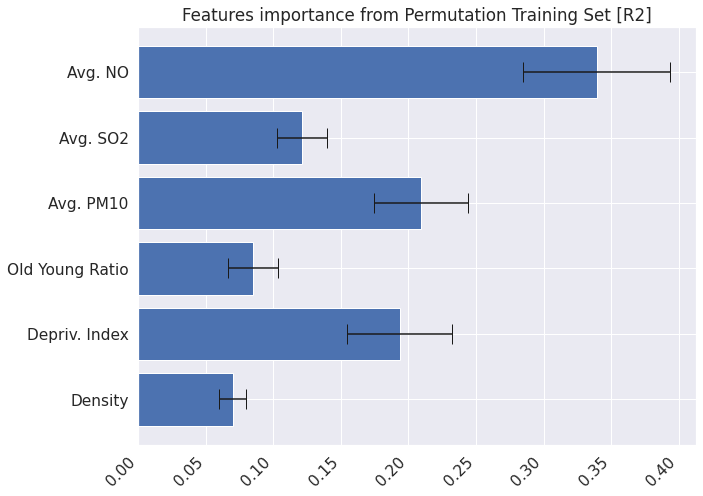

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}


In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.33084 +/-  0.01846 
    Test set average RMSE:  0.89843 +/-  0.08802 
  Training set average R2:  0.94570 +/-  0.00522 
      Test set average R2:  0.59526 +/-  0.06509 
Taining:
             Density ,    0.07393 +/-    0.01135 ,   -0.00715 +/-    0.01046 ,    0.00000 ,    0.00000 ,    0.00000 ,    1.00000
        Com. Density ,    0.22517 +/-    0.03982 ,    0.05723 +/-    0.03063 ,    0.00000 ,   51.00000 ,    0.00000 ,   76.00000
       Depriv. Index ,    0.14430 +/-    0.02974 ,    0.02383 +/-    0.01885 ,    0.00000 ,    2.00000 ,    0.00000 ,    2.50000
            Latitude ,    0.67328 +/-    0.08838 ,    0.27920 +/-    0.05313 ,  100.00000 ,    0.00000 ,  100.00000 ,    0.00000
     Old Young Ratio ,    0.10251 +/-    0.01883 ,    0.00781 +/-    0.01338 ,    0.00000 ,    0.00000 ,    0.00000 ,    2.50000
           Avg. PM10 ,    0.18195 +/-    0.04481 ,    0

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}


In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.35859 +/-  0.02317 
    Test set average RMSE:  0.98884 +/-  0.10023 
  Training set average R2:  0.93611 +/-  0.00742 
      Test set average R2:  0.50509 +/-  0.10836 
Taining:
             Density ,    0.07569 +/-    0.02186 ,   -0.00476 +/-    0.01619 ,    0.00000 ,    0.00000 ,    0.00000 ,    1.50000
        Com. Density ,    1.39328 +/-    0.41564 ,    0.52841 +/-    0.13673 ,   95.50000 ,    3.50000 ,   99.50000 ,    0.50000
       Depriv. Index ,    0.11909 +/-    0.06873 ,    0.01275 +/-    0.02665 ,    0.50000 ,    2.50000 ,    0.00000 ,    2.50000
     Old Young Ratio ,    0.21160 +/-    0.08226 ,    0.03568 +/-    0.03202 ,    0.00000 ,   17.50000 ,    0.00000 ,   12.50000
           Avg. PM10 ,    0.21741 +/-    0.09900 ,    0.02278 +/-    0.03765 ,    0.00000 ,   14.50000 ,    0.00000 ,   12.50000
            Avg. SO2 ,    0.09458 +/-    0.03629 ,    0

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}


In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.37119 +/-  0.02191 
    Test set average RMSE:  1.03072 +/-  0.10372 
  Training set average R2:  0.93133 +/-  0.00699 
      Test set average R2:  0.47182 +/-  0.09994 
Taining:
             Density ,    0.13260 +/-    0.02562 ,   -0.00092 +/-    0.01824 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
       Depriv. Index ,    0.53836 +/-    0.12090 ,    0.18697 +/-    0.05083 ,   39.50000 ,   41.00000 ,   53.00000 ,   41.50000
     Old Young Ratio ,    0.19386 +/-    0.03543 ,    0.01354 +/-    0.01848 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.50000
           Avg. PM10 ,    0.41247 +/-    0.10788 ,    0.09603 +/-    0.04968 ,    8.00000 ,   21.50000 ,    3.50000 ,    9.50000
            Avg. SO2 ,    0.17810 +/-    0.03592 ,    0.02573 +/-    0.01969 ,    0.00000 ,    0.00000 ,    0.50000 ,    0.50000
             Avg. NO ,    0.58543 +/-    0.13622 ,    0

<Figure size 720x720 with 0 Axes>